
## Libraries installation

In [1]:
!pip install catboost
!pip install --user --upgrade catboost
!pip install --user --upgrade ipywidgets
!pip install shap
!pip install slearn
!jupyter nbextension enable --py widgetsnbextension


     |████████████████████████████████| 64.4MB 60kB/s 
Requirement already up-to-date: catboost in /usr/local/lib/python3.6/dist-packages (0.22)
Requirement already up-to-date: ipywidgets in /usr/local/lib/python3.6/dist-packages (7.5.1)
     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394124 sha256=ae1840707bbd45837e05307f042d1715e42630f281734b3a42e5ce97d8ee3291
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap
ERROR: Could not find a version that satisfies the requirement slearn (from versions: none)
ERROR: No matching distribution found for slearn
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
import os
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)

import matplotlib.pyplot as plt

import catboost
print(catboost.__version__)

0.22


## Reading the data

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving komplett org.csv to komplett org.csv
User uploaded file "komplett org.csv" with length 3946216 bytes


In [65]:
df = pd.read_csv('komplett org.csv')
df.head()

datum             häst plac  dist  ... h5_plac  h5_dist h5_spår h5_odds
0  2020-04-04     GIANT SHADOW  1:a  2640  ...       1   1640.0    11.0    1,72
1  2020-04-04     NERO MAXIMUS    2  2640  ...       3   2140.0     8.0    3,21
2  2020-04-04  GLOBAL UNSPOKED    3  2640  ...       0   2640.0    10.0   23,03
3  2020-04-04          GANYBOY    4  2640  ...       2   2100.0     NaN    7,50
4  2020-04-04  ELDORADO MEARAS    5  2640  ...       1   2140.0    10.0    9,72

[5 rows x 28 columns]

In [66]:
df['spår'] = df.spår.astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27623 entries, 0 to 27622
Data columns (total 28 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   datum    27623 non-null  object 
 1   häst     27623 non-null  object 
 2   plac     27623 non-null  object 
 3   dist     27623 non-null  int64  
 4   start    27623 non-null  object 
 5   spår     27562 non-null  float64
 6   vodds    27623 non-null  object 
 7   podds    27623 non-null  object 
 8   h1_plac  26061 non-null  object 
 9   h1_dist  26072 non-null  float64
 10  h1_spår  24072 non-null  float64
 11  h1_odds  26059 non-null  object 
 12  h2_plac  26057 non-null  object 
 13  h2_dist  26058 non-null  float64
 14  h2_spår  23832 non-null  float64
 15  h2_odds  26041 non-null  object 
 16  h3_plac  26026 non-null  object 
 17  h3_dist  26027 non-null  float64
 18  h3_spår  23581 non-null  float64
 19  h3_odds  26013 non-null  object 
 20  h4_plac  26015 non-null  object 
 21  h4_dist  260

In [0]:
#
df.loc[df.plac == 'd','plac']= 14
df.loc[df.plac == '0','plac']= 13
df.loc[df.plac == '0:a','plac']= 13
df.loc[df.plac == '1:a','plac']= '1'
df['plac'] = df.loc[:,'plac'].astype('float')
df.h1_plac.value_counts(dropna=False)

df.loc[df.start == 'AUTOSTART','start']= 0
df.loc[df.start == 'VOLTSTART','start']= 1
df['start'] = df.start.astype('int64')

df.vodds = df['vodds'].str.replace(',','.').astype('float')

## podds: räkna om 'x.xx - y.yy' till ett medelvärde
def new_podds(p):
  x=p.replace(',' , '.')
  sp=x.split('-')

  x=sp[0]
  if len(sp) == 2:
    x = (float(sp[0])+float(sp[1]))/2
  
  return x

# print(df['podds'].str.contains('-').sum())
df['podds'] = df['podds'].apply(lambda x: new_podds(x))
df['podds'] = df.podds.astype('float')
##

#### hx_hist['plac'] #### 
# byt '0' till 13
df.loc[df.h1_plac == '0','h1_plac']= 13
df.loc[df.h2_plac == '0','h2_plac']= 13
df.loc[df.h3_plac == '0','h3_plac']= 13
df.loc[df.h4_plac == '0','h4_plac']= 13
df.loc[df.h5_plac == '0','h5_plac']= 13

# byt 'd' till 14
df.loc[df.h1_plac == 'd','h1_plac']= 14
df.loc[df.h2_plac == 'd','h2_plac']= 14
df.loc[df.h3_plac == 'd','h3_plac']= 14
df.loc[df.h4_plac == 'd','h4_plac']= 14
df.loc[df.h5_plac == 'd','h5_plac']= 14

# ett 'r' för mycket
df.loc[df.h1_plac == '0r','h1_plac']= 13
df.loc[df.h2_plac == '0r','h2_plac']= 13
df.loc[df.h3_plac == '0r','h3_plac']= 13
df.loc[df.h4_plac == '0r','h4_plac']= 13
df.loc[df.h5_plac == '0r','h5_plac']= 13

df.loc[df.h1_plac == '2r','h1_plac']= 2
df.loc[df.h2_plac == '2r','h2_plac']= 2
df.loc[df.h3_plac == '2r','h3_plac']= 2
df.loc[df.h4_plac == '2r','h4_plac']= 2
df.loc[df.h5_plac == '2r','h5_plac']= 2

df.loc[df.h1_plac == '3r','h1_plac']= 3
df.loc[df.h2_plac == '3r','h2_plac']= 3
df.loc[df.h3_plac == '3r','h3_plac']= 3
df.loc[df.h4_plac == '3r','h4_plac']= 3
df.loc[df.h5_plac == '3r','h5_plac']= 3

df.loc[df.h1_plac == '4r','h1_plac']= 4
df.loc[df.h2_plac == '4r','h2_plac']= 4
df.loc[df.h3_plac == '4r','h3_plac']= 4
df.loc[df.h4_plac == '4r','h4_plac']= 4
df.loc[df.h5_plac == '4r','h5_plac']= 4

# byt 'k' till NaN
df.loc[df.h1_plac == 'k', 'h1_dist'] = df.loc[df.h1_plac == 'k','h1_dist'].apply(lambda x: np.nan) 
df.loc[df.h1_plac == 'k', 'h1_spår'] = df.loc[df.h1_plac == 'k','h1_spår'].apply(lambda x: np.nan) 
df.loc[df.h1_plac == 'k', 'h1_odds'] = df.loc[df.h1_plac == 'k','h1_odds'].apply(lambda x: np.nan) 
df.loc[df.h1_plac == 'k', 'h1_plac'] = df.loc[df.h1_plac == 'k','h1_plac'].apply(lambda x: np.nan) 

df.loc[df.h2_plac == 'k', 'h2_dist'] = df.loc[df.h2_plac == 'k','h2_dist'].apply(lambda x: np.nan) 
df.loc[df.h2_plac == 'k', 'h2_spår'] = df.loc[df.h2_plac == 'k','h2_spår'].apply(lambda x: np.nan) 
df.loc[df.h2_plac == 'k', 'h2_odds'] = df.loc[df.h2_plac == 'k','h2_odds'].apply(lambda x: np.nan) 
df.loc[df.h2_plac == 'k', 'h2_plac'] = df.loc[df.h2_plac == 'k','h2_plac'].apply(lambda x: np.nan) 

df.loc[df.h3_plac == 'k', 'h3_dist'] = df.loc[df.h3_plac == 'k','h3_dist'].apply(lambda x: np.nan) 
df.loc[df.h3_plac == 'k', 'h3_spår'] = df.loc[df.h3_plac == 'k','h3_spår'].apply(lambda x: np.nan) 
df.loc[df.h3_plac == 'k', 'h3_odds'] = df.loc[df.h3_plac == 'k','h3_odds'].apply(lambda x: np.nan) 
df.loc[df.h3_plac == 'k', 'h3_plac'] = df.loc[df.h3_plac == 'k','h3_plac'].apply(lambda x: np.nan) 

df.loc[df.h4_plac == 'k', 'h4_dist'] = df.loc[df.h4_plac == 'k','h4_dist'].apply(lambda x: np.nan) 
df.loc[df.h4_plac == 'k', 'h4_spår'] = df.loc[df.h4_plac == 'k','h4_spår'].apply(lambda x: np.nan) 
df.loc[df.h4_plac == 'k', 'h4_odds'] = df.loc[df.h4_plac == 'k','h4_odds'].apply(lambda x: np.nan) 
df.loc[df.h4_plac == 'k', 'h4_plac'] = df.loc[df.h4_plac == 'k','h4_plac'].apply(lambda x: np.nan) 

df.loc[df.h5_plac == 'k', 'h5_dist'] = df.loc[df.h5_plac == 'k','h5_dist'].apply(lambda x: np.nan) 
df.loc[df.h5_plac == 'k', 'h5_spår'] = df.loc[df.h5_plac == 'k','h5_spår'].apply(lambda x: np.nan) 
df.loc[df.h5_plac == 'k', 'h5_odds'] = df.loc[df.h5_plac == 'k','h5_odds'].apply(lambda x: np.nan) 
df.loc[df.h5_plac == 'k', 'h5_plac'] = df.loc[df.h5_plac == 'k','h5_plac'].apply(lambda x: np.nan) 

# byt 'p' till NaN
df.loc[df.h2_plac == 'p', 'h2_dist'] = df.loc[df.h2_plac == 'p','h2_dist'].apply(lambda x: np.nan)
df.loc[df.h2_plac == 'p', 'h2_spår'] = df.loc[df.h2_plac == 'p','h2_spår'].apply(lambda x: np.nan)
df.loc[df.h2_plac == 'p', 'h2_odds'] = df.loc[df.h2_plac == 'p','h2_odds'].apply(lambda x: np.nan)
df.loc[df.h2_plac == 'p', 'h2_plac'] = df.loc[df.h2_plac == 'p','h2_plac'].apply(lambda x: np.nan)

df.loc[df.h5_plac == 'p']
df.loc[df.h5_plac == 'p', 'h5_dist'] = df.loc[df.h5_plac == 'p','h5_dist'].apply(lambda x: np.nan)
df.loc[df.h5_plac == 'p', 'h5_spår'] = df.loc[df.h5_plac == 'p','h5_spår'].apply(lambda x: np.nan)
df.loc[df.h5_plac == 'p', 'h5_odds'] = df.loc[df.h5_plac == 'p','h5_odds'].apply(lambda x: np.nan)
df.loc[df.h5_plac == 'p', 'h5_plac'] = df.loc[df.h5_plac == 'p','h5_plac'].apply(lambda x: np.nan)

# gör till int32
df['h1_plac'] = df.h1_plac.astype('float')
df['h2_plac'] = df.h2_plac.astype('float')
df['h3_plac'] = df.h3_plac.astype('float')
df['h4_plac'] = df.h4_plac.astype('float')
df['h5_plac'] = df.h5_plac.astype('float')

#### hx_odds ####

#h1
df.h1_odds = df['h1_odds'].str.replace(',','.')
df.loc[df.h1_odds == '-', 'h1_odds'] = df.loc[df.h1_odds == '-','h1_odds'].apply(lambda x: np.nan)
df.loc[df.h1_odds=='GDK','h1_odds'] = df.loc[df.h1_odds == 'GDK','h1_odds'].apply(lambda x: np.nan)
df['h1_odds'] = df.h1_odds.astype('float')

#h2
df.h2_odds = df['h2_odds'].str.replace(',','.')
df.loc[df.h2_odds == '-', 'h2_odds'] = df.loc[df.h2_odds == '-','h2_odds'].apply(lambda x: np.nan)
df.loc[df.h2_odds=='GDK','h2_odds'] = df.loc[df.h2_odds == 'GDK','h2_odds'].apply(lambda x: np.nan)
df.loc[df.h2_odds=='gdk','h2_odds'] = df.loc[df.h2_odds == 'gdk','h2_odds'].apply(lambda x: np.nan)
df['h2_odds'] = df.h2_odds.astype('float')

#h3
df.h3_odds = df['h3_odds'].str.replace(',','.')
df.loc[df.h3_odds == '-', 'h3_odds'] = df.loc[df.h3_odds == '-','h3_odds'].apply(lambda x: np.nan)
df.loc[df.h3_odds=='GDK','h3_odds'] = df.loc[df.h3_odds == 'GDK','h3_odds'].apply(lambda x: np.nan)
df.loc[df.h3_odds=='gdk','h3_odds'] = df.loc[df.h3_odds == 'gdk','h3_odds'].apply(lambda x: np.nan)
df.loc[df.h3_odds=='b-lp','h3_odds'] = df.loc[df.h3_odds == 'b-lp','h3_odds'].apply(lambda x: np.nan)
df.loc[df.h3_odds=='ejg','h3_odds'] = df.loc[df.h3_odds == 'ejg','h3_odds'].apply(lambda x: np.nan)
df.loc[df.h3_odds=='ut','h3_odds'] = df.loc[df.h3_odds == 'ut','h3_odds'].apply(lambda x: np.nan)
df['h3_odds'] = df.h3_odds.astype('float')

#h4
df.h4_odds = df['h4_odds'].str.replace(',','.')
df.loc[df.h4_odds == '-', 'h4_odds'] = df.loc[df.h4_odds == '-','h4_odds'].apply(lambda x: np.nan)
df.loc[df.h4_odds=='GDK','h4_odds'] = df.loc[df.h4_odds == 'GDK','h4_odds'].apply(lambda x: np.nan)
df.loc[df.h4_odds=='gdk','h4_odds'] = df.loc[df.h4_odds == 'gdk','h4_odds'].apply(lambda x: np.nan)
df.loc[df.h4_odds=='b-lp','h4_odds'] = df.loc[df.h4_odds == 'b-lp','h4_odds'].apply(lambda x: np.nan)
df.loc[df.h4_odds=='ejg','h4_odds'] = df.loc[df.h4_odds == 'ejg','h4_odds'].apply(lambda x: np.nan)
df.loc[df.h4_odds=='ut','h4_odds'] = df.loc[df.h4_odds == 'ut','h4_odds'].apply(lambda x: np.nan)
df['h4_odds'] = df.h4_odds.astype('float')

#h5
df.h5_odds = df['h5_odds'].str.replace(',','.')
df.loc[df.h5_odds == '-', 'h5_odds'] = df.loc[df.h5_odds == '-','h5_odds'].apply(lambda x: np.nan)
df.loc[df.h5_odds=='GDK','h5_odds'] = df.loc[df.h5_odds == 'GDK','h5_odds'].apply(lambda x: np.nan)
df.loc[df.h5_odds=='gdk','h5_odds'] = df.loc[df.h5_odds == 'gdk','h5_odds'].apply(lambda x: np.nan)
df.loc[df.h5_odds=='b-lp','h5_odds'] = df.loc[df.h5_odds == 'b-lp','h5_odds'].apply(lambda x: np.nan)
df.loc[df.h5_odds=='B-lp','h5_odds'] = df.loc[df.h5_odds == 'B-lp','h5_odds'].apply(lambda x: np.nan)
df.loc[df.h5_odds=='ejg','h5_odds'] = df.loc[df.h5_odds == 'ejg','h5_odds'].apply(lambda x: np.nan)
df.loc[df.h5_odds=='ut','h5_odds'] = df.loc[df.h5_odds == 'ut','h5_odds'].apply(lambda x: np.nan)
df.loc[df.h5_odds=='P','h5_odds'] = df.loc[df.h5_odds == 'P','h5_odds'].apply(lambda x: np.nan)
#df.loc[df.h5_odds=='B-lp']
df['h5_odds'] = df.h5_odds.astype('float')


## Exploring the data

In [68]:
#df.drop('Unnamed: 0',axis=1,inplace=True)
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27623 entries, 0 to 27622
Data columns (total 28 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   datum    27623 non-null  object 
 1   häst     27623 non-null  object 
 2   plac     27623 non-null  float64
 3   dist     27623 non-null  int64  
 4   start    27623 non-null  int64  
 5   spår     27562 non-null  float64
 6   vodds    27623 non-null  float64
 7   podds    27623 non-null  float64
 8   h1_plac  25988 non-null  float64
 9   h1_dist  25999 non-null  float64
 10  h1_spår  24005 non-null  float64
 11  h1_odds  25910 non-null  float64
 12  h2_plac  25939 non-null  float64
 13  h2_dist  25940 non-null  float64
 14  h2_spår  23723 non-null  float64
 15  h2_odds  25880 non-null  float64
 16  h3_plac  25930 non-null  float64
 17  h3_dist  25931 non-null  float64
 18  h3_spår  23496 non-null  float64
 19  h3_odds  25847 non-null  float64
 20  h4_plac  25877 non-null  float64
 21  h4_dist  258

plac          dist  ...       h5_spår       h5_odds
count  27623.000000  27623.000000  ...  23037.000000  25631.000000
mean       7.709952   2184.544655  ...      5.399835     15.785095
std        4.860088    396.855748  ...      3.323020     22.729928
min        1.000000   1600.000000  ...      1.000000      1.000000
25%        3.000000   2100.000000  ...      3.000000      3.450000
50%        6.000000   2140.000000  ...      5.000000      7.400000
75%       13.000000   2160.000000  ...      8.000000     17.995000
max       14.000000   3700.000000  ...     18.000000    689.300000

[8 rows x 26 columns]

In [69]:

df.describe(include='object')

datum              häst
count        27623             27623
unique         352              7294
top     2018-02-24  ON TRACK PIRATEN
freq            93                73


#Create X and y and keep 20% in ZX Zy for validate
Endast för regression: Ny kolumn vinst som är vodds - 1.0 för 1:an och -1 för andra  
Möjligt att man skall mjuka upp 2-3 plats med 0

Endast för klassificering: ny kolumn vann för 1:an 0 för övrigt

In [103]:
sz = int(df.shape[0]*0.2)
print(df.shape, sz)
X_all = df.drop(['datum', 'plac'],axis=1)              
y_all = ((df.plac==1)  * df.vodds) -1

X = X_all.iloc[sz:]  #keep for validate
y = y_all[sz:]  #keep for validate
ZX = X_all.iloc[:sz,:]
Zy = y_all[:sz]
print(X.shape, y.shape, ZX.shape, Zy.shape)
X.shape[0]+ZX.shape[0] == df.shape[0]

(27623, 28) 5524
(22099, 26) (22099,) (5524, 26) (5524,)


True

Categorical features declaration

In [104]:
X.info()
cat_features = ['häst', 'start']
print(cat_features)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22099 entries, 5524 to 27622
Data columns (total 26 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   häst     22099 non-null  object 
 1   dist     22099 non-null  int64  
 2   start    22099 non-null  int64  
 3   spår     22038 non-null  float64
 4   vodds    22099 non-null  float64
 5   podds    22099 non-null  float64
 6   h1_plac  20789 non-null  float64
 7   h1_dist  20799 non-null  float64
 8   h1_spår  19214 non-null  float64
 9   h1_odds  20737 non-null  float64
 10  h2_plac  20743 non-null  float64
 11  h2_dist  20744 non-null  float64
 12  h2_spår  19000 non-null  float64
 13  h2_odds  20699 non-null  float64
 14  h3_plac  20739 non-null  float64
 15  h3_dist  20740 non-null  float64
 16  h3_spår  18819 non-null  float64
 17  h3_odds  20676 non-null  float64
 18  h4_plac  20700 non-null  float64
 19  h4_dist  20700 non-null  float64
 20  h4_spår  18656 non-null  float64
 21  h4_odds  

#GridSearch

In [0]:
xxxxxfrom sklearn.model_selection import GridSearchCV

param_grid = {
    "learning_rate": [0.001, 0.01, 0.5],
}

clf = CatBoostClassifier(
    iterations=20, 
    cat_features=cat_features, 
    verbose=20
)
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=3)
results = grid_search.fit(X_train, y_train)
results.best_estimator_.get_params()

In [0]:
from catboost import CatBoostRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics

estimator = CatBoostRegressor( 
    iterations = 500,
    cat_features = cat_features,
)
#In the next step, I have to specify the tunable parameters
# and the range of values.

parameters = {
    'learning_rate': [0.0001, 0.01, 0.1],
    'depth': [4, 6, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
   }

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    #scoring = 'neg_mean_absolute_error' ,
    n_jobs = 10,
    cv=10,
    verbose=True
)

rand_search = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=parameters,
    #scoring = 'neg_mean_absolute_error',
    n_jobs = 10,
    cv = 10,
    verbose=True
)


In [0]:
results =grid_search.fit(X, y)
#rand_search.fit(X,y)

print(grid_search.best_estimator_)
print(grid_search.best_score_)
print('A',results.best_estimator_.get_params())
print('B',grid_search.best_params_)
#print(rand_search.best_estimator_)
#print(rand_search.best_score_)
#rand_search.best_params_

In [26]:
print(grid_search.param_grid)
print('best score:', results.best_score_, grid_search.best_score_)
print('BEst estimator Params',results.best_estimator_.get_params())
print('Best params',grid_search.best_params_)


{'learning_rate': [0.0001, 0.01, 0.1], 'depth': [4, 6, 10], 'l2_leaf_reg': [1, 3, 5, 7, 9]}
best score: 0.002313683660637278 0.002313683660637278
BEst estimator Params {'cat_features': ['start', 'spår'], 'loss_function': 'RMSE', 'l2_leaf_reg': 7, 'depth': 10, 'learning_rate': 0.01, 'iterations': 500}
Best params {'depth': 10, 'l2_leaf_reg': 7, 'learning_rate': 0.01}


###A new try for details

In [0]:
estimator2 = CatBoostRegressor( 
    iterations = 500,
    l2_leaf_reg = 7,
    cat_features = cat_features,
)

parameters2 = {
    'learning_rate': [0.001, 0.01, 0.2],
    'depth': [10, 12],
   }

grid_search2 = GridSearchCV(
    estimator=estimator2,
    param_grid = parameters2,
    #scoring = 'neg_mean_absolute_error' ,
    n_jobs = 10,
    cv=10,
    verbose=True
)
results2 =grid_search2.fit(X, y)

In [30]:
print(grid_search2.param_grid)
print('best score:', results2.best_score_, grid_search2.best_score_)
print('BEst estimator Params',results2.best_estimator_.get_params())
print('Best params',grid_search2.best_params_)


{'learning_rate': [0.001, 0.01, 0.2], 'depth': [10, 12]}
best score: 0.002313683660637278 0.002313683660637278
BEst estimator Params {'cat_features': ['start', 'spår'], 'loss_function': 'RMSE', 'l2_leaf_reg': 7, 'depth': 10, 'learning_rate': 0.01, 'iterations': 500}
Best params {'depth': 10, 'learning_rate': 0.01}


# Training the model

In [0]:
from catboost import CatBoostRegressor
from catboost import Pool
pool = Pool(data=X, label=y, cat_features=cat_features)
train_pool = Pool(
    cat_features=cat_features,
    data=X, 
    label=y
)

validation_pool = Pool(
    cat_features=cat_features,
    data=ZX, 
    label=Zy
)


In [106]:
cbr = CatBoostRegressor(iterations=5000, 
                        #loss_function='MAE',
                        #depth= 10, 
                        #l2_leaf_reg = 7, 
                        #learning_rate = 0.001, 
                        early_stopping_rounds=50 )

cbr.fit(train_pool, eval_set=validation_pool, verbose=5)


Learning rate set to 0.030347
0:	learn: 4.0120924	test: 4.0377234	best: 4.0377234 (0)	total: 21.7ms	remaining: 1m 48s
5:	learn: 4.0045845	test: 4.0361467	best: 4.0361467 (5)	total: 128ms	remaining: 1m 46s
10:	learn: 3.9985641	test: 4.0353579	best: 4.0353579 (10)	total: 241ms	remaining: 1m 49s
15:	learn: 3.9930123	test: 4.0345588	best: 4.0345588 (15)	total: 342ms	remaining: 1m 46s
20:	learn: 3.9899676	test: 4.0342177	best: 4.0342177 (20)	total: 449ms	remaining: 1m 46s
25:	learn: 3.9852604	test: 4.0340306	best: 4.0338782 (22)	total: 561ms	remaining: 1m 47s
30:	learn: 3.9805655	test: 4.0336811	best: 4.0336550 (29)	total: 674ms	remaining: 1m 48s
35:	learn: 3.9750076	test: 4.0332548	best: 4.0332454 (34)	total: 778ms	remaining: 1m 47s
40:	learn: 3.9692318	test: 4.0331480	best: 4.0330940 (38)	total: 869ms	remaining: 1m 45s
45:	learn: 3.9631212	test: 4.0331641	best: 4.0330940 (38)	total: 978ms	remaining: 1m 45s
50:	learn: 3.9556970	test: 4.0333386	best: 4.0330940 (38)	total: 1.08s	remaining: 1

In [107]:
print('Model is fitted: {}'.format(cbr.is_fitted()))
print('Model params:\n{}'.format(cbr.get_params()))

Model is fitted: True
Model params:
{'early_stopping_rounds': 50, 'loss_function': 'RMSE', 'iterations': 5000}


## Predict(ZX)


In [108]:
ZyHat = cbr.predict(ZX)

feat = pd.DataFrame(ZX.columns,columns=['feature']) 
feat['imp'] = cbr.feature_importances_

feat.sort_values(by='imp',ascending=False)

feature        imp
4     vodds  11.969075
17  h3_odds  10.534601
5     podds  10.144974
20  h4_spår   7.533515
23  h5_dist   4.914969
21  h4_odds   4.451435
16  h3_spår   4.197879
9   h1_odds   4.107900
0      häst   3.886644
18  h4_plac   3.541087
19  h4_dist   3.302064
11  h2_dist   3.218588
24  h5_spår   2.963032
8   h1_spår   2.887462
13  h2_odds   2.731552
1      dist   2.183496
10  h2_plac   2.183434
6   h1_plac   2.059248
15  h3_dist   2.056409
7   h1_dist   1.917958
2     start   1.903956
25  h5_odds   1.895611
14  h3_plac   1.682780
22  h5_plac   1.663183
3      spår   1.656692
12  h2_spår   0.412456

## Metrics

In [109]:
from sklearn.metrics import mean_absolute_error as MAE
from sklearn import metrics

print(MAE(Zy,ZyHat))
print(np.sqrt(metrics.mean_squared_error(Zy,ZyHat)))
print(pd.DataFrame(ZyHat).describe())


1.3074543633645472
4.033094028598945
                 0
count  5524.000000
mean     -0.306980
std       0.143772
min      -0.775954
25%      -0.317678
50%      -0.272733
75%      -0.239642
max       2.526126


best treshold: 1.6500000000000021 vinst: -1.0


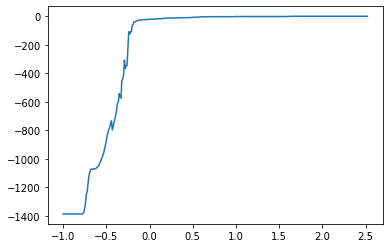

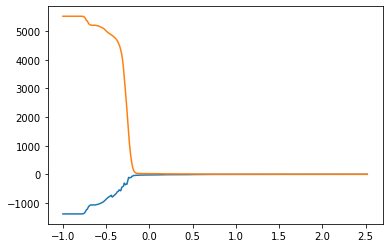

In [111]:
import numpy as np

vinst=[]
cnt = []
vMax=-1000
limMax=-100
rng=np.arange(-1, 2.53,0.01)
for lim in rng:
  v=Zy[ZyHat>=lim].sum()
  if v > vMax:
    vMax=v
    limMax=lim

  vinst.append(v)
  cnt.append(Zy[ZyHat>=lim].count())
print('best treshold:', limMax,'vinst:',vMax) 
plt.plot(rng,vinst)
plt.show()
plt.plot(rng,vinst)
plt.plot(rng,cnt)

In [112]:
limit = limMax
print('Treshold:', limMax)
print('Antal veckor (ca):', Zy.shape[0]/78.5)
print('Antal Lopp:', ZX.shape[0])                       
print('Antal satsade:',  Zy[ZyHat>=limit].count(), 
      'Antal fel =', Zy[ZyHat>=limit].count() -  (Zy[ZyHat>=limit] >= 0).sum(),
      'Antal rätt:', (Zy[ZyHat>=limit] >= 0).sum()  )
print('Vinst:', Zy[ZyHat>=limit].sum())


Treshold: 1.6500000000000021
Antal veckor (ca): 70.36942675159236
Antal Lopp: 5524
Antal satsade: 1 Antal fel = 1 Antal rätt: 0
Vinst: -1.0


# EXTRA 
##Working with dataset

There are several ways of passing dataset to training - using X,y (the initial matrix) or using Pool class.
Pool class is the class for storing the dataset. In the next few blocks we'll explore the ways to create a Pool object.

You can use Pool class if the dataset has more than just X and y (for example, it has sample weights or groups) or if the dataset is large and it takes long time to read it into python.

In [0]:
from catboost import Pool
pool = Pool(data=X, label=y, cat_features=cat_features)

In [0]:
train_pool = Pool(
    data=X, 
    label=y, 
    cat_features=cat_features
)

validation_pool = Pool(
    data=ZX, 
    label=Zy, 
    cat_features=cat_features
)

## Selecting the objective function

Possible options for binary classification:

`Logloss` for binary target.

`CrossEntropy` for probabilities in target.

In [0]:
model = CatBoostClassifier(
    iterations=500,
    verbose=5,
    #learning_rate=0.1,
    #loss_function='CrossEntropy'
)
model.fit(train_pool, eval_set=validation_pool, verbose=True)

print('Model is fitted: {}'.format(model.is_fitted()))
print('Model params:\n{}'.format(model.get_params()))

## Stdout of the training

In [0]:
model = CatBoostClassifier(
    iterations=500,
     verbose=5,
     #task_type='GPU'
)
model.fit(train_pool, eval_set=validation_pool);

## Metrics calculation and graph plotting

In [0]:
model = CatBoostClassifier(
    iterations=50,
    learning_rate=0.5,
    custom_loss=['AUC', 'Accuracy']
)

model.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Model comparison

In [0]:
model1 = CatBoostClassifier(
    learning_rate=0.7,
    iterations=100,
    train_dir='learning_rate_0.7'
)

model2 = CatBoostClassifier(
    learning_rate=0.01,
    iterations=100,
    train_dir='learning_rate_0.01'
)

model1.fit(train_pool, eval_set=validation_pool, verbose=20)
model2.fit(train_pool, eval_set=validation_pool, verbose=20);

0:	learn: 0.3258230	test: 0.3243318	best: 0.3243318 (0)	total: 18.3ms	remaining: 1.81s
20:	learn: 0.1691117	test: 0.1596568	best: 0.1594555 (18)	total: 339ms	remaining: 1.27s
40:	learn: 0.1631269	test: 0.1582470	best: 0.1582470 (40)	total: 664ms	remaining: 955ms
60:	learn: 0.1574848	test: 0.1576933	best: 0.1570204 (46)	total: 973ms	remaining: 622ms
80:	learn: 0.1530052	test: 0.1576496	best: 0.1570204 (46)	total: 1.29s	remaining: 303ms
99:	learn: 0.1508312	test: 0.1578638	best: 0.1570204 (46)	total: 1.59s	remaining: 0us

bestTest = 0.1570204018
bestIteration = 46

Shrink model to first 47 iterations.
0:	learn: 0.6853670	test: 0.6853478	best: 0.6853478 (0)	total: 17.8ms	remaining: 1.77s
20:	learn: 0.5575475	test: 0.5568142	best: 0.5568142 (20)	total: 270ms	remaining: 1.02s
40:	learn: 0.4678037	test: 0.4663655	best: 0.4663655 (40)	total: 515ms	remaining: 742ms
60:	learn: 0.4029115	test: 0.4011251	best: 0.4011251 (60)	total: 737ms	remaining: 471ms
80:	learn: 0.3551495	test: 0.3530158	best:

In [0]:
from catboost import MetricVisualizer
MetricVisualizer(['learning_rate_0.7', 'learning_rate_0.01']).start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Best iteration

In [0]:
model = CatBoostClassifier(
    iterations=100,
#     use_best_model=False
)
model.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [0]:
print('Tree count: ' + str(model.tree_count_))

Tree count: 95


## Cross-validation

In [0]:
from catboost import cv

params = {
    'loss_function': 'Logloss',
    'iterations': 500,
    'custom_loss': 'AUC',
    #'learning_rate': 0.5,
}

cv_data = cv(
    params = params,
    pool = train_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    verbose=True
)

In [0]:
cv_data.head(10)

iterations  test-Logloss-mean  ...  test-AUC-mean  test-AUC-std
0           0           0.656518  ...       0.746891      0.037835
1           1           0.622816  ...       0.791644      0.026621
2           2           0.593795  ...       0.790937      0.029154
3           3           0.566179  ...       0.792369      0.029156
4           4           0.539265  ...       0.817370      0.015786
5           5           0.518338  ...       0.817478      0.016103
6           6           0.498295  ...       0.817890      0.015912
7           7           0.478726  ...       0.818175      0.015097
8           8           0.459876  ...       0.822536      0.010559
9           9           0.443571  ...       0.821927      0.010801

[10 rows x 7 columns]

In [0]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Best validation Logloss score, not stratified: 0.2331±0.0056 on step 285


In [0]:
from catboost import cv

params = {
    'loss_function': 'Logloss',
    'iterations': 500,
    'custom_loss': 'AUC',
    #'learning_rate': 0.5,
}

cv_data = cv(
    params = params,
    pool = train_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=True,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [0]:
best_value = cv_data['test-Logloss-mean'].min()
best_iter = cv_data['test-Logloss-mean'].values.argmin()

print('Best validation Logloss score, stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Best validation Logloss score, stratified: 0.2331±0.0056 on step 285


## Sklearn Grid Search

In [0]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "learning_rate": [0.001, 0.01, 0.5],
}

clf = CatBoostClassifier(
    iterations=400, 
    cat_features=cat_features, 
    verbose=20
)
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=3)
results = grid_search.fit(X, y)
results.best_estimator_.get_params()

In [0]:
y.value_counts(dropna=False)

False    20130
True      1969
Name: plac, dtype: int64

## Overfitting Detector

In [0]:
model_with_early_stop = CatBoostClassifier(
    iterations=500,
    #learning_rate=0.5,
    early_stopping_rounds=20
)

model_with_early_stop.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=True,
    plot=False
);

Learning rate set to 0.092027
0:	learn: 0.5880933	test: 0.5868277	best: 0.5868277 (0)	total: 17.1ms	remaining: 8.51s
1:	learn: 0.5033823	test: 0.5002210	best: 0.5002210 (1)	total: 32.5ms	remaining: 8.1s
2:	learn: 0.4482501	test: 0.4455377	best: 0.4455377 (2)	total: 48.5ms	remaining: 8.03s
3:	learn: 0.4032164	test: 0.4008079	best: 0.4008079 (3)	total: 64.1ms	remaining: 7.95s
4:	learn: 0.3673653	test: 0.3647730	best: 0.3647730 (4)	total: 79.8ms	remaining: 7.9s
5:	learn: 0.3364615	test: 0.3332133	best: 0.3332133 (5)	total: 95.1ms	remaining: 7.83s
6:	learn: 0.3181652	test: 0.3153194	best: 0.3153194 (6)	total: 111ms	remaining: 7.83s
7:	learn: 0.3039481	test: 0.3014885	best: 0.3014885 (7)	total: 127ms	remaining: 7.8s
8:	learn: 0.2912071	test: 0.2890249	best: 0.2890249 (8)	total: 142ms	remaining: 7.75s
9:	learn: 0.2787333	test: 0.2769657	best: 0.2769657 (9)	total: 158ms	remaining: 7.76s
10:	learn: 0.2700356	test: 0.2682965	best: 0.2682965 (10)	total: 175ms	remaining: 7.78s
11:	learn: 0.265031

In [0]:
print(model_with_early_stop.tree_count_)

47


### Overfitting Detector with eval metric

In [0]:
model_with_early_stop = CatBoostClassifier(
    eval_metric='AUC',
    iterations=200,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=False,
    plot=True
);

In [0]:
print(model_with_early_stop.tree_count_)

## Model predictions

In [0]:
model = CatBoostClassifier(iterations=200, learning_rate=0.03)
model.fit(train_pool, verbose=50);

0:	learn: 0.6562528	total: 46ms	remaining: 9.16s
50:	learn: 0.1918638	total: 1.87s	remaining: 5.45s
100:	learn: 0.1652364	total: 4.23s	remaining: 4.14s
150:	learn: 0.1581722	total: 6.94s	remaining: 2.25s
199:	learn: 0.1551516	total: 9.7s	remaining: 0us


In [0]:
print(model.predict(ZX))

['False' 'False' 'False' ... 'False' 'False' 'False']


In [0]:
print(model.predict_proba(ZX))

[[0.5594 0.4406]
 [0.8742 0.1258]
 [0.9654 0.0346]
 ...
 [0.9634 0.0366]
 [0.9682 0.0318]
 [0.9798 0.0202]]


In [0]:
raw_pred = model.predict(
    ZX,
    prediction_type='RawFormulaVal'
)

print(raw_pred)

[-0.2386 -1.9389 -3.328  ... -3.2718 -3.4146 -3.8797]


In [0]:
from numpy import exp

sigmoid = lambda x: 1 / (1 + exp(-x))

probabilities = sigmoid(raw_pred)

print(probabilities)

[0.4406 0.1258 0.0346 ... 0.0366 0.0318 0.0202]


## Select decision boundary

![](https://habrastorage.org/webt/y4/1q/yq/y41qyqfm9mcerp2ziys48phpjia.png)

In [0]:
import matplotlib.pyplot as plt
from catboost.utils import get_roc_curve
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

curve = get_roc_curve(cbc, validation_pool)
(fpr, tpr, thresholds) = curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

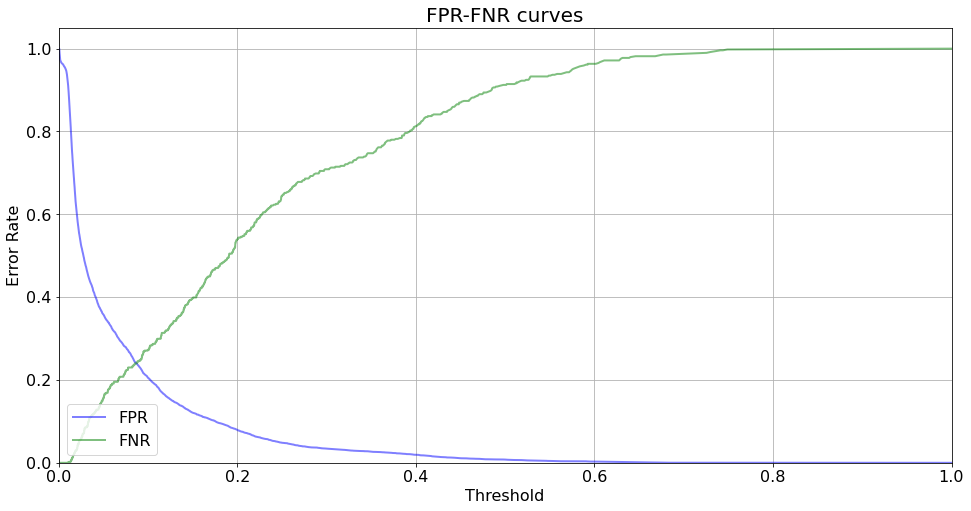

In [0]:
plt.figure(figsize=(16, 8))
style = {'alpha':0.5, 'lw':2}

plt.plot(thresholds, fpr, color='blue', label='FPR', **style)
plt.plot(thresholds, fnr, color='green', label='FNR', **style)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16);

In [0]:
from catboost.utils import select_threshold

print(select_threshold(model, validation_pool, FNR=0.01))
print(select_threshold(model, validation_pool, FPR=0.01))

0.01487475653214014
0.46880977398198376


## Metric evaluation on a new dataset

In [0]:
metrics = model.eval_metrics(
    data=validation_pool,
    metrics=['Logloss','AUC'],
    ntree_start=0,
    ntree_end=0,
    eval_period=1,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [0]:
print('AUC values:\n{}'.format(np.array(metrics['AUC'])))

AUC values:
[0.7755 0.8091 0.8102 0.8115 0.8115 0.8232 0.8268 0.8275 0.8282 0.8299
 0.8295 0.8293 0.8306 0.83   0.8321 0.8313 0.8308 0.8312 0.8315 0.834
 0.8336 0.8337 0.8335 0.8342 0.8337 0.8335 0.8336 0.8336 0.8335 0.8337
 0.8339 0.8342 0.835  0.8358 0.8352 0.8352 0.8355 0.8356 0.836  0.836
 0.836  0.8362 0.836  0.836  0.836  0.836  0.8362]


## Feature importances

### Prediction values change

Default feature importances for binary classification is PredictionValueChange - how much on average does the model change when the feature value changes.
These feature importances are non negative.
They are normalized and sum to 1, so you can look on these values like percentage of importance.

In [0]:
np.array(model.get_feature_importance(prettified=True))

array([['vodds', 44.840690802999],
       ['podds', 14.765374467304033],
       ['h2_dist', 4.458567466796526],
       ['h5_plac', 4.1357201420116585],
       ['h4_plac', 3.654223247815214],
       ['h4_spår', 2.797272428964602],
       ['h1_odds', 2.7099500546741275],
       ['spår', 2.1642902917206635],
       ['h2_plac', 2.1634470389468152],
       ['h5_spår', 1.7733840957512779],
       ['h5_odds', 1.623288262361287],
       ['start', 1.5429023261560297],
       ['h2_spår', 1.4971832684598765],
       ['h1_dist', 1.3369273957179768],
       ['h3_plac', 1.3302636311415872],
       ['h5_dist', 1.3017013947797196],
       ['h3_dist', 1.2275011350457883],
       ['h3_spår', 1.2197823061247375],
       ['h3_odds', 1.0862636309424876],
       ['h2_odds', 0.9400906926112822],
       ['h4_dist', 0.92026356773534],
       ['h1_spår', 0.8934621820849736],
       ['h1_plac', 0.5998653298458348],
       ['h4_odds', 0.5129838381343883],
       ['dist', 0.5046010018747878]], dtype=object)

### Loss function change

The non default feature importance approximates how much the optimized loss function will change if the value of the feature changes.
This importances might be negative if the feature has bad influence on the loss function.
The importances are not normalized, the absolute value of the importance has the same scale as the optimized loss value.
To calculate this importance value you need to pass train_pool as an argument.

In [0]:
np.array(model.get_feature_importance(
    train_pool, 
    'LossFunctionChange', 
    prettified=True
))

array([['vodds', 0.04732924877087907],
       ['podds', 0.005711292559774234],
       ['h1_dist', 0.0005525243527889356],
       ['h4_plac', 0.0005401863326786327],
       ['h5_plac', 0.0005375377967958284],
       ['h1_odds', 0.0005158421406454006],
       ['spår', 0.0004842243827412329],
       ['h4_spår', 0.00047451507567222717],
       ['h2_spår', 0.00045055870439755785],
       ['h5_odds', 0.0004135595688784799],
       ['h5_spår', 0.0004135509254573899],
       ['h2_plac', 0.00040791259051978224],
       ['h3_dist', 0.00037625461114781933],
       ['h3_spår', 0.00035154863370112643],
       ['h3_plac', 0.00033400606505087915],
       ['h1_spår', 0.0002674214202434966],
       ['h3_odds', 0.0002660140500892749],
       ['start', 0.00026586744698611775],
       ['h2_dist', 0.00024190538867180367],
       ['h1_plac', 0.00019943393586205338],
       ['h4_dist', 0.00017938261634659058],
       ['h2_odds', 0.00016680149104486564],
       ['h4_odds', 0.00014893418956773985],
       ['h5

### Shap values

In [0]:
print(model.predict_proba([X.iloc[2,:]]))
print(model.predict_proba([X.iloc[91,:]]))

CatBoostError: ignored

In [0]:
shap_values = model.get_feature_importance(
    validation_pool, 
    'ShapValues'
)
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
print(shap_values.shape)

(5524, 25)


In [0]:
proba = model.predict_proba([X.iloc[1,:]])[0]
raw = model.predict([X.iloc[1,:]], prediction_type='RawFormulaVal')[0]
print('Probabilities', proba)
print('Raw formula value %.4f' % raw)
print('Probability from raw value %.4f' % sigmoid(raw))

CatBoostError: ignored

In [0]:
import shap

shap.initjs()
shap.force_plot(expected_value, shap_values[1,:], ZX.iloc[1,:])

In [0]:
proba = model.predict_proba([X.iloc[91,:]])[0]
raw = model.predict([X.iloc[91,:]], prediction_type='RawFormulaVal')[0]
print('Probabilities', proba)
print('Raw formula value %.4f' % raw)
print('Probability from raw value %.4f' % sigmoid(raw))

CatBoostError: ignored

In [0]:
import shap
shap.initjs()
shap.force_plot(expected_value, shap_values[91,:], ZX.iloc[91,:])

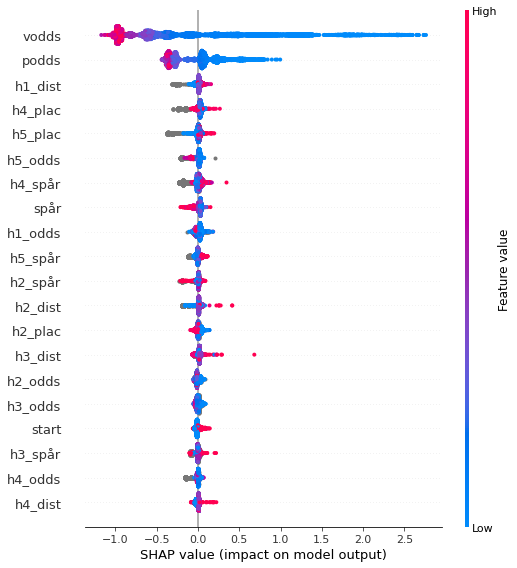

In [0]:
shap.summary_plot(shap_values, ZX)

## Snapshotting

In [0]:
!rm 'catboost_info/snapshot.bkp'

model = CatBoostClassifier(
    iterations=100,
    save_snapshot=True,
    snapshot_file='snapshot.bkp',
    snapshot_interval=1
)

model.fit(train_pool, eval_set=validation_pool, verbose=10);

Learning rate set to 0.193326
0:	learn: 0.5564949	test: 0.5561139	best: 0.5561139 (0)	total: 18.9ms	remaining: 1.87s
10:	learn: 0.2178126	test: 0.2134187	best: 0.2134187 (10)	total: 171ms	remaining: 1.38s
20:	learn: 0.1812606	test: 0.1732781	best: 0.1732781 (20)	total: 316ms	remaining: 1.19s
30:	learn: 0.1748005	test: 0.1626846	best: 0.1626846 (30)	total: 473ms	remaining: 1.05s
40:	learn: 0.1726962	test: 0.1602887	best: 0.1602887 (40)	total: 644ms	remaining: 927ms
50:	learn: 0.1712455	test: 0.1593634	best: 0.1593634 (50)	total: 798ms	remaining: 766ms
60:	learn: 0.1700027	test: 0.1587262	best: 0.1587262 (60)	total: 967ms	remaining: 619ms
70:	learn: 0.1686842	test: 0.1579603	best: 0.1578436 (68)	total: 1.14s	remaining: 464ms
80:	learn: 0.1677571	test: 0.1576176	best: 0.1576176 (80)	total: 1.3s	remaining: 305ms
90:	learn: 0.1672519	test: 0.1571767	best: 0.1571767 (90)	total: 1.46s	remaining: 144ms
99:	learn: 0.1668679	test: 0.1571213	best: 0.1571159 (94)	total: 1.61s	remaining: 0us

bestT

## Saving the model

In [0]:
model = CatBoostClassifier(iterations=500)
model.fit(train_pool, eval_set=validation_pool, verbose=True)
model.save_model('catboost_model.bin')
model.save_model('catboost_model.json', format='json')

Learning rate set to 0.092027
0:	learn: 0.5880933	test: 0.5868277	best: 0.5868277 (0)	total: 17.8ms	remaining: 8.9s
1:	learn: 0.5033823	test: 0.5002210	best: 0.5002210 (1)	total: 33.3ms	remaining: 8.3s
2:	learn: 0.4482501	test: 0.4455377	best: 0.4455377 (2)	total: 49ms	remaining: 8.12s
3:	learn: 0.4032164	test: 0.4008079	best: 0.4008079 (3)	total: 64.8ms	remaining: 8.04s
4:	learn: 0.3673653	test: 0.3647730	best: 0.3647730 (4)	total: 81.2ms	remaining: 8.04s
5:	learn: 0.3364615	test: 0.3332133	best: 0.3332133 (5)	total: 96.9ms	remaining: 7.98s
6:	learn: 0.3181652	test: 0.3153194	best: 0.3153194 (6)	total: 113ms	remaining: 7.94s
7:	learn: 0.3039481	test: 0.3014885	best: 0.3014885 (7)	total: 129ms	remaining: 7.92s
8:	learn: 0.2912071	test: 0.2890249	best: 0.2890249 (8)	total: 145ms	remaining: 7.89s
9:	learn: 0.2787333	test: 0.2769657	best: 0.2769657 (9)	total: 161ms	remaining: 7.88s
10:	learn: 0.2700356	test: 0.2682965	best: 0.2682965 (10)	total: 177ms	remaining: 7.87s
11:	learn: 0.2650317

In [0]:
model.load_model('catboost_model.bin')
print(model.get_params())
print(model.learning_rate_)

{'iterations': 500, 'loss_function': 'Logloss', 'logging_level': 'Verbose', 'verbose': 1}
0.09202700108


## Hyperparameter tunning

In [0]:
tuned_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=3,
    random_strength=1,
    bagging_temperature=1
)

tuned_model.fit(
    X, y,
    cat_features=cat_features,
    verbose=True,
    eval_set=(ZX, Zy),
    plot=True
);

In [0]:
tuned_model.get_params()

{'bagging_temperature': 1,
 'depth': 6,
 'iterations': 1000,
 'l2_leaf_reg': 3,
 'learning_rate': 0.03,
 'random_strength': 1}

# Speeding up the training

In [0]:
fast_model = CatBoostClassifier(
    boosting_type='Plain',
    rsm=0.5,
    one_hot_max_size=50,
    leaf_estimation_iterations=1,
    max_ctr_complexity=1,
    iterations=100,
    learning_rate=0.3,
    bootstrap_type='Bernoulli',
    subsample=0.5
)
fast_model.fit(
    X, y,
    cat_features=cat_features,
    verbose=False,
    eval_set=(ZX, Zy),
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

# Reducing model size

In [0]:
small_model = CatBoostClassifier(
    learning_rate=0.03,
    iterations=500,
    model_size_reg=50,
    max_ctr_complexity=1,
    ctr_leaf_count_limit=100
)
small_model.fit(
    X, y,
    cat_features=cat_features,
    verbose=False,
    eval_set=(ZX, Zy),
    plot=True
);
small_model.get_params()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{'ctr_leaf_count_limit': 100,
 'iterations': 500,
 'learning_rate': 0.03,
 'max_ctr_complexity': 1,
 'model_size_reg': 50}